In [5]:
# Import the libraries we need to use in this lab
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split ,cross_val_score ,GridSearchCV
from sklearn.preprocessing import StandardScaler , normalize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier ,plot_tree 
from sklearn.svm import LinearSVC 
from sklearn.metrics import roc_auc_score ,accuracy_score ,roc_curve , classification_report, confusion_matrix,   ConfusionMatrixDisplay
import seaborn as sns  

## Load the dataset

In [6]:
def load_data (url): 

    # download the dataset and read the input data
    data = pd.read_csv(url) 
    return data

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"
raw_data = load_data(url)
raw_data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


## Dataset Analysis

  Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

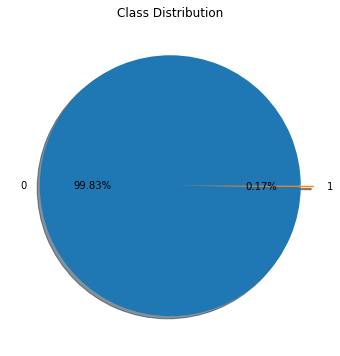

Correlation with Target:


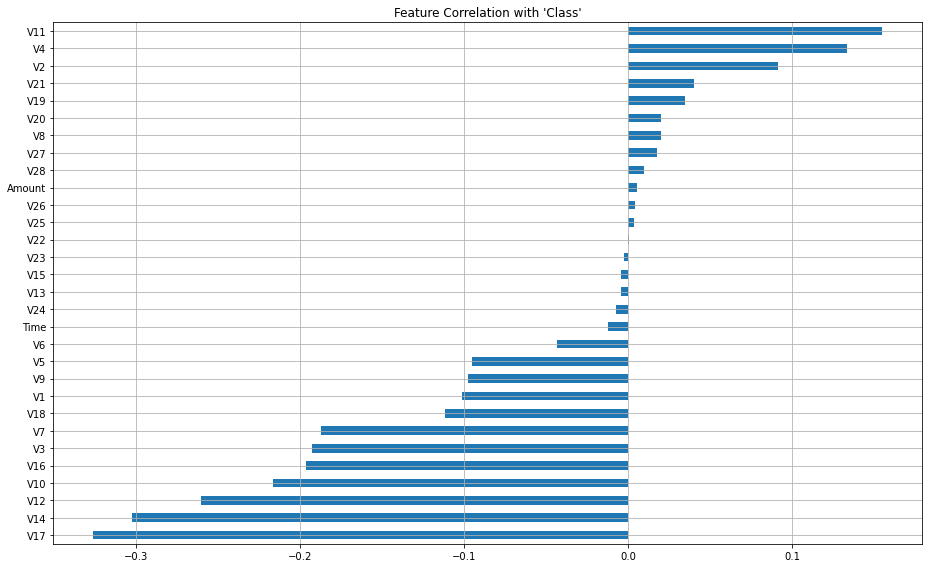

In [7]:
def eda_report(df, target_column=None):
    print("="*50)
    print("  Basic Info:")
    print("="*50)
    print(df.info())
    print("\n")

    print("="*50)
    print(" Descriptive Statistics:")
    print("="*50)
    print(df.describe())
    print("\n")

    print("="*50)
    print(" Missing Values:")
    print("="*50)
    print(df.isnull().sum()[df.isnull().sum() > 0])
    print("\n")

 
    print("="*50)
    print(f"  Target Variable Distribution ({target_column}):")
    print("="*50)
    print(df[target_column].value_counts(normalize=True).rename('proportion'))
    print("\n")

        # Pie chart of class distribution
    class_counts = df[target_column].value_counts()
    labels = class_counts.index
    explode = [0.1 if i==1 else 0 for i in range(len(labels))]
    plt.figure(figsize=(6,6))
    plt.pie(class_counts, labels=labels, autopct='%1.2f%%', explode=explode, shadow=True)
    plt.title("Class Distribution")
    plt.show()

    print("="*50)
    print("Correlation with Target:")
    print("="*50)

    correlations = df.corr()[target_column].drop(target_column)
    correlations.sort_values().plot(kind='barh', figsize=(13, 8) )
    plt.title(f"Feature Correlation with '{target_column}'")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
eda_report(raw_data, target_column='Class')

In [46]:
def preprocess_data(raw_data):
    #exclude the Time ans class variables from the dataset 
    i    = abs(raw_data.corr()['Class']).drop('Class').sort_values(ascending=False)[:6].to_dict()
    i =  list(i.keys()) 
    i =  sorted(i ,key=lambda x: int(x[1:]))
  
    X_data = raw_data[i].values
    y  = raw_data.Class.values
    # standardize features
    X_data_trans = StandardScaler().fit_transform(X_data)
    # data normalization
    x = normalize(X_data_trans) 
    return x ,y   
x ,y   =  preprocess_data(raw_data)
 

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) 


#### Build a Decision Tree Classifier model with Scikit-Learn

In [48]:
#Compute the sample weights
def compute_weights(y_train):

    w  = compute_sample_weight('balanced', y_train)
    return w
w_train = compute_weights(y_train)

In [49]:
# build and train decision tree classifier model
def train_decision_tree(x_train , y_train ,w_train):
    param_grid_dt = {
        'max_depth': [2, 4, 6, 8, 10],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }
    # Create base model
    dtreeclass = DecisionTreeClassifier( random_state= 35)
    # Setup GridSearch
    greed_search_dt = GridSearchCV(estimator = dtreeclass , param_grid =param_grid_dt , cv =5 , scoring= 'roc_auc',n_jobs=-1,
                               verbose=1) 
    # Fit with sample weights
    greed_search_dt.fit(x_train , y_train , sample_weight= w_train )
    # Best model
    best_dtree =  greed_search_dt.best_estimator_
    print("Best DT params:", greed_search_dt.best_params_)
    return best_dtree    
    
dtreeclass  = train_decision_tree(x_train , y_train , w_train )
 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best DT params: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}


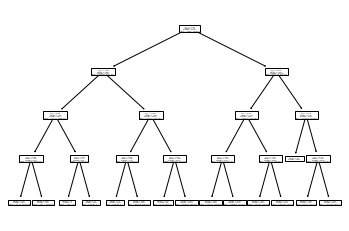

In [50]:
#Visualize the tree:
plot_tree(dtreeclass  )
plt.show()

In [51]:
y_hat_dt = dtreeclass.predict(x_test)
 
#compute the probabilities of the test samples belonging to the class of fraudulent transactions 
y_prob_pred = dtreeclass.predict_proba(x_test)[:,1]
 

#### Evaluation

In [65]:
# ROC-AUC
def calculate_auc_score (y_test,y_prob_pred   ):
    roc_auc =  roc_auc_score(y_test,y_prob_pred)
    print(f' {roc_auc }Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc ))
    return roc_auc

In [66]:
def plot_roc_curve(y_test,y_prob_pred ,name= 'name'):
    fpr , tpr , tresholds = roc_curve(y_test,y_prob_pred)
 
    # visulaize the ROC  
    roc_auc = calculate_auc_score (y_test,y_prob_pred)
 
    plt.figure(figsize= (8,6))
    plt.plot(fpr ,tpr  , lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{ name } Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

 0.9523613761094014Decision Tree ROC-AUC score : 0.000


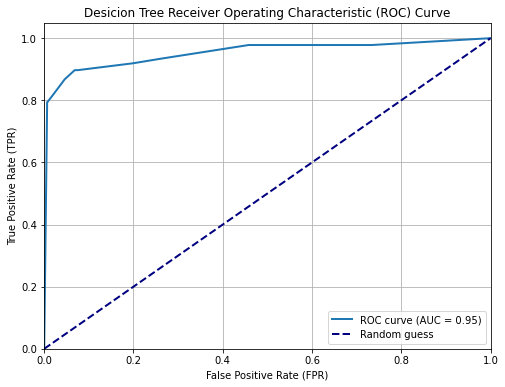

In [67]:
# ROC-AUC
# compute FPR (False Positive Rate), TPR (True Positive Rate) و Thresholds
plot_roc_curve(y_test,y_prob_pred ,'Desicion Tree') 

classification report for Decision Tree model :

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     85307
           1       0.02      0.90      0.04       136

    accuracy                           0.93     85443
   macro avg       0.51      0.91      0.50     85443
weighted avg       1.00      0.93      0.96     85443
 


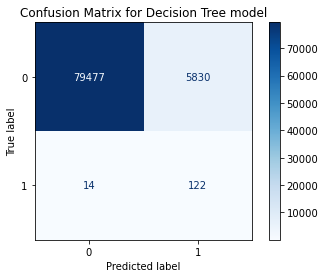

In [68]:
print(f'classification report for Decision Tree model :\n\n{classification_report(y_test, y_hat_dt)} ')

cm = confusion_matrix(y_test, y_hat_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree model")
plt.show()

# Build a Support Vector Machine model

In [69]:
svm = LinearSVC(class_weight= 'balanced' , random_state= 31 , loss= 'hinge' ,fit_intercept=False )  
svm.fit(x_train, y_train)

c:\Users\Zahra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

### Evaluate

In [57]:

# compute the probabilities of the test samples belonging to the class of fraudulent transactions
y_prob_svm = svm.decision_function(x_test)
y_hat_svm = svm.predict(x_test)

 0.9485945743367036Decision Tree ROC-AUC score : 0.000


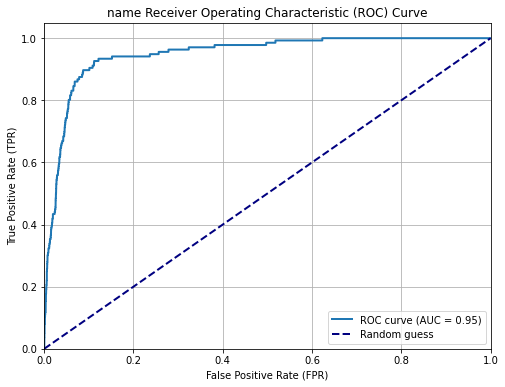

In [70]:
plot_roc_curve(y_test,y_prob_svm)

classification report for SVM  model                precision    recall  f1-score   support

           0     0.9999    0.5679    0.7244     85307
           1     0.0036    0.9779    0.0072       136

    accuracy                         0.5685     85443
   macro avg     0.5018    0.7729    0.3658     85443
weighted avg     0.9984    0.5685    0.7232     85443



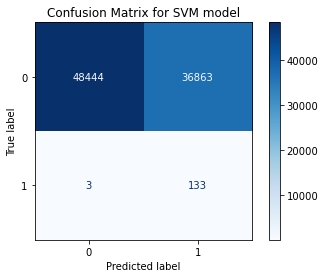

In [71]:
print(f'classification report for SVM  model  {classification_report(y_test, y_hat_svm, digits=4)}')
cm_svm = confusion_matrix(y_test, y_hat_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM model")
plt.show()